In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [2]:
yf.pdr_override()
df = pdr.get_data_yahoo("RTY=F", start="2016-03-01", end="2023-03-27")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()
df.to_csv("Price_RTYF.csv")

[*********************100%***********************]  1 of 1 completed


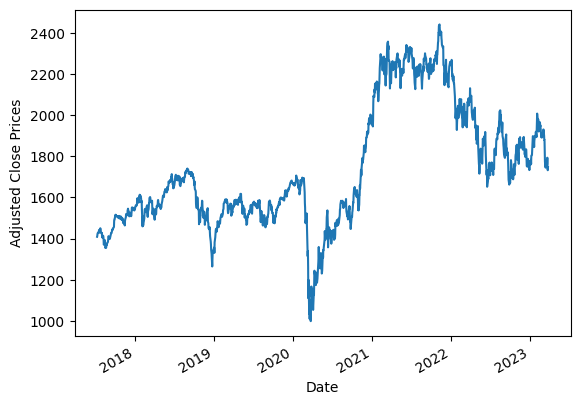

In [3]:
df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [24]:
df.dropna(inplace=True)

In [25]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values
x.shape
y.shape

(268,)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [27]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 8, 'bootstrap': False}


In [29]:
model = RandomForestRegressor(n_estimators=500, random_state=1, min_samples_split=2, min_samples_leaf=1, max_depth=8, bootstrap=False)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[1769.80004883 1772.39996338 1664.39980786 1738.80004883 1813.93801514
 1693.11019409 1872.2800293  1763.65280664 2083.87204883 1977.30320801
 1947.09997559 1746.25920703 1829.06797803 1853.09997559 1893.70335775
 1760.45001221 1746.25920703 1940.66000977 1731.23001782 1805.18041846
 1802.36638184 1833.32001953 1857.20004883 1865.20642737 1882.98538025
 1858.38004883 1899.65002441 1762.36159351 1855.85560938 1894.56669108
 2015.04960107 1988.3983938  1772.39996338 1871.17758789 1790.66382471
 1692.97157959 1837.75       1889.95717017 2009.15156274 1905.58718359
 1771.96798096 1940.66420972 1708.64401123 2094.60009766 1920.22741138
 1885.30004883 1769.80004883 1823.13522852 1885.55904883 1954.61197559
 2071.16404883 2009.45437402 1778.68338037 2061.23388916 1802.36638184
 1790.66382471 1991.09997559 1731.20603271 1910.66000977 1893.70335775
 1708.64401123 1894.56669108 1728.59997559 1898.39518359 1808.95532532
 1973.12081299 1819.27941504 1921.25283398 1731.47798267 2079.22804883]
(70,)

In [30]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 1.9859
Mean Squared Error: 23.4573
Root Mean Squared Error: 4.8433
(R^2) Score: 0.9979
Train Score : 100.00% and Test Score : 99.79% using Random Tree Regressor.
Accuracy: 99.9 %.


In [31]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
   Unnamed: 0  Predictions
2  2023-03-23  1664.399808
2    1664.399808
Name: Predictions, dtype: float64
Sell price and date
8    2083.872049
Name: Predictions, dtype: float64


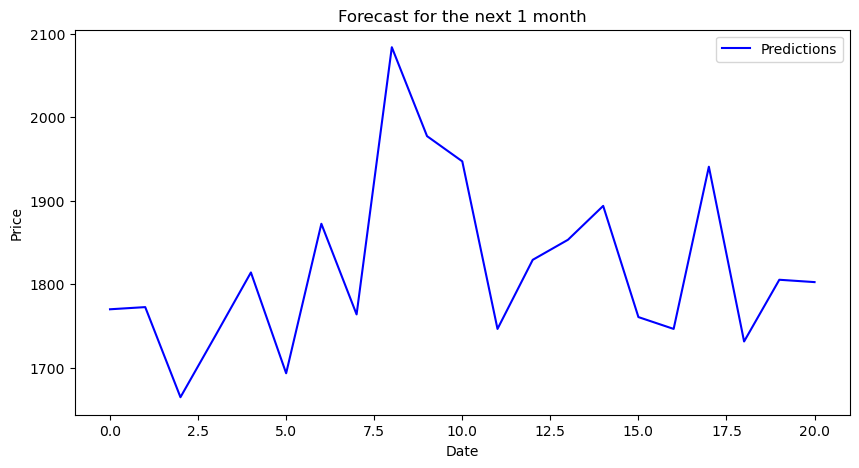

In [32]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print(onemonth_buy.loc[:, 'Predictions'])
print("Sell price and date")
print(onemonth_sell.loc[:, 'Predictions'])
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the next 1 month", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()